In [0]:
!pip install -q pydrive

    100% |████████████████████████████████| 993kB 21.3MB/s 


Importamos las librerias necesarias

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sn    # libreria para el gráfico de correlacion


Accedemos a google drive donde se encuentra alojada nuestra base de datos

In [0]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load hour.csv
myfile = drive.CreateFile({'id': '1219Iw0Wb5eRUUDfUR97vX72TtXFVhTdb'})
myfile.GetContentFile('hour.csv')

# Load day.csv
myfile2 = drive.CreateFile({'id': '1k18ZgnLKgv-cusgvmEcJrXv29rrqJkfi'})
myfile2.GetContentFile('day.csv')

In [56]:
data_hour = pd.read_csv('hour.csv')
data_hour.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


###  Analisis Exploratorio
El analisis exploratorio es necesario para entender las carácteristicas de la base de datos, de esta manera se podrá adaptar mejor el modelo de machine learning pues se consideraran los factores expecíficos de los datos para modificar los hiperparametros del modelo con el fin de buscar la mejor configuración para los datos.



Se realiza un gráfico que indica la correlación que existe entre la variable a predecir cnt y las otras variables. Se puede notar que en la parte de hr, holiday, entre otras no tienen influencia sobre la variable cnt o en otras palabras no aportar información. En contraparte, la variable casual y registered son las que mayor correlación presentan con respecto a la variable a predecir, esto nos indica que son variables que aportan mucha información del comportamiento de la variable cnt. 

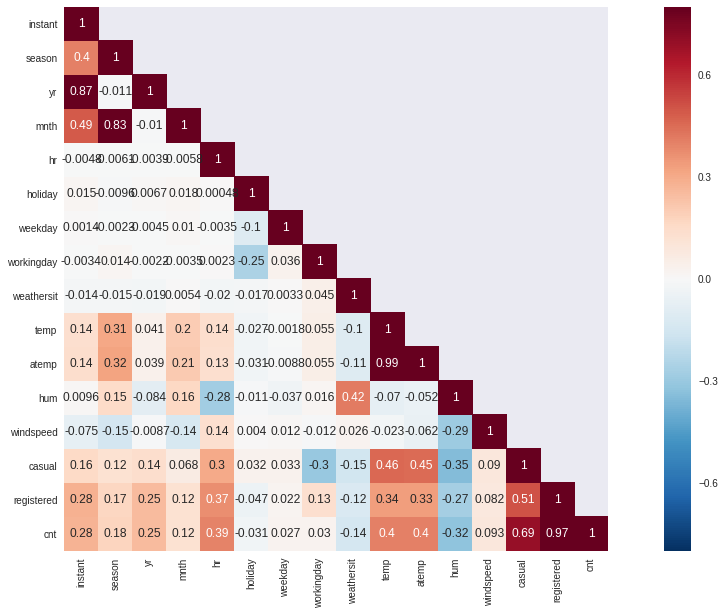

In [57]:
corrMatt = data_hour.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [0]:
from datetime import datetime

for indice in range(len(data_hour)):
  dt = datetime.strptime(data_hour.dteday[indice], '%Y-%m-%d')
  new_value = dt.day
  data_hour.loc[indice, 'dteday'] = new_value

Para el entrenamiento del modelo no se tomo en cuenta la variable de la fecha pues no aportaba información relevante. Para el entrenamiento del modelo se realizaron cuatro enfoques, el primero utilizando 15 carácteristicas, las mismas se pueden observar en la variable "features_train" . El segundo utilizando unicamente las variables que más correlación tienen (casual y registered) con la variable a predecir (cnt), en el tercer enfoque, se consideran unicamente las dos variables con mayor correlación, se analizan los datos por cuartiles y se reemplazan los datos anomalos por valores que esten dentro de los cuartiles, con esta ultima forma se lográ que los datos ajusten más a una distribución normal. Finalmente en el ultimo enfoque, se consideran los 15 features pero las variables de casual y registered han sido modificadas para que no contengan outliers.

### Primer Enfoque (15 features)

In [58]:
## Separamos en atributos y etiquetas
## Etiquetas, labels son los valores que vamos a predecir.

#X = data_hour.iloc[:,2:15].values

feature_train=['instant',	'season',	'yr',	'mnth',	'hr', 'holiday',
               'weekday',	'workingday',	'weathersit',	'temp',	'atemp',	'hum',
               'windspeed',	'casual',	'registered']

X=data_hour[feature_train]

y = data_hour['cnt']


#len(X), len(y)
#print(X)
#print(y)

# Encabezados para posterior uso sin la variable cnt
np.shape(feature_train)

(15,)

Se realizo la división de los datos en entrenamiento y test, de igual manera la misma que se utilizo para que todo tenga relación

In [0]:
## Finalmente, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True)

Se importan las librerias necesarias para el modelo de regresion con arboles de desición

In [0]:
from sklearn.tree import DecisionTreeRegressor # Importamos las librerías necesarias 
from sklearn import tree
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from pydotplus import graph_from_dot_data
from IPython.display import Image as PImage



En el entrenamiento del modelo, se realizaron varias pruebas modificando los parametros pero el mayor cambio se dio al utilizar una configuración con profundida de 7, con esta variable se debe tener cuidado para no sobre entrenar o sub entrenar un modelo.

In [61]:
rtree = DecisionTreeRegressor(max_depth=7, min_samples_leaf=6,
                              min_samples_split=30)
rtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
rsal = rtree.predict(X_test)    # Obtenemos las salidas del modelo para datos de
                                # test

In [63]:
E1test=r2_score(y_test,rsal)

print('El r2 score para los datos de testeo es de:',
      r2_score(y_test,rsal))    # mediante el r2 score validamos la precision 
                               # del modelo, se obtiene un valor para
                               # datos de test

El r2 score para los datos de testeo es de: 0.995540057136473


In [0]:
rsaltrain = rtree.predict(X_train)  # se obtiene los resultados para los datos
                                # de entrenamiento

In [65]:
E1train=r2_score(y_train,rsaltrain)
print('El r2 score para los datos de entrenamiento es de:',
      r2_score(y_train,rsaltrain))        # Se obtiene un r2 score para los 
                                # datos de entrenamiento

El r2 score para los datos de entrenamiento es de: 0.996465897572796


### Segundo Enfoque (Features con mayor correlación a cnt)

In [66]:
## Separamos en atributos y etiquetas
## Etiquetas, labels son los valores que vamos a predecir.


feature_train=['casual',	'registered']

X=data_hour[feature_train]

y = data_hour['cnt']


#len(X), len(y)
#print(X)
#print(y)

# Encabezados para posterior uso sin la variable cnt
np.shape(feature_train)

(2,)

In [0]:
## Finalmente, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True)

In [68]:
rtree = DecisionTreeRegressor(max_depth=7, min_samples_leaf=6,
                              min_samples_split=30)
rtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [69]:
rsal = rtree.predict(X_test)    # Obtenemos las salidas del modelo para datos de
                                # test
E2test=r2_score(y_test,rsal)

print('El r2 score para los datos de testeo es de:',
      r2_score(y_test,rsal))    # mediante el r2 score validamos la precision 
                               # del modelo, se obtiene un valor para
                               # datos de test

El r2 score para los datos de testeo es de: 0.9955583398799388


In [70]:
rsaltrain = rtree.predict(X_train)  # se obtiene los resultados para los datos
E2train=r2_score(y_train,rsaltrain)
                                # de entrenamiento
print('El r2 score para los datos de testeo es de:',
      r2_score(y_train,rsaltrain))        # Se obtiene un r2 score para los 
                                # datos de entrenamiento

El r2 score para los datos de testeo es de: 0.9965084054291679


### Tercer Enfoque (Features con mayor correlacion a cnt + cuartiles)

In [71]:
#Calculamos los cuantiles:
# Cuantil 1  es de 25%
# Cuantil 2  es de 50%
# Cuantil 3  es de 75%
q25=np.percentile(data_hour[['registered']], 25)
q75=np.percentile(data_hour[['registered']], 75)
RIC=q75-q25
LI=q25-1.5*RIC
LS=q75+1.5*RIC
#Verificamos los cortes:
# LI: Limite Inferior
# SL: Limite superior
# Los valores que estan fuera de este rango, se lo considera valores atipicos
print(LI,LS)

-245.0 499.0


In [72]:
# Creamos una nueva variable con los datos del dataset
data_hour2 = data_hour.copy()

type(data_hour2)

pandas.core.frame.DataFrame

In [0]:
# Se crea una nueva columna y los valores que son "atipicos" son reemplazos con
#el cuantil 3
data_hour2['registered2'] = data_hour2['registered'].where(data_hour2['registered']<=LS,q75)

In [74]:
data_hour2.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,registered2
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,137.728580
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,116.606252
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,34.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,115.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,220.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,499.000000


In [75]:
# Realizamos el mismo analisis para la caracteristica "casual"
q25=np.percentile(data_hour2[['casual']], 25)
q75=np.percentile(data_hour2[['casual']], 75)
RIC=q75-q25
LI=q25-1.5*RIC
LS=q75+1.5*RIC
print(LI,LS)

-62.0 114.0


In [0]:
# Se crea una nueva columna para casual. Para los datos atipicos son reemplazado
# con el cuantil 3
data_hour2['casual2'] = data_hour2['casual'].where(data_hour2['casual']<=LS,q75)

In [77]:
data_hour2.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,registered2,casual2
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,137.728580,26.631970
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,116.606252,27.206421
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,34.000000,4.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,115.000000,17.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,220.000000,48.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,499.000000,114.000000


Se puede observar al comparar los valores de las variables casual vs casual2 y registered vs registered2 que las segundas variables ya no contienen datos anomalos (con respecto a los cuartiles). Finalmente, con estas nuevas variables se realizo un ultimo entrenamiento del modelo.

In [78]:
## Separamos en atributos y etiquetas
## Etiquetas, labels son los valores que vamos a predecir.


feature_train=['casual2',	'registered2']

X=data_hour2[feature_train]

y = data_hour['cnt']


#len(X), len(y)
#print(X)
#print(y)

# Encabezados para posterior uso sin la variable cnt
np.shape(feature_train)

(2,)

In [0]:
## Finalmente, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True)

In [80]:
rtree = DecisionTreeRegressor(max_depth=7, min_samples_leaf=6,min_samples_split=30)
rtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [81]:
rsal = rtree.predict(X_test)    # Obtenemos las salidas del modelo para datos de
                                # test
E3test=r2_score(y_test,rsal)

print('El r2 score para los datos de testeo es de:',
      r2_score(y_test,rsal))          # mediante el r2 score validamos 
                               # la precision 
                               # del modelo, se obtiene un valor para
                               # datos de test

El r2 score para los datos de testeo es de: 0.9669073963230964


In [82]:
rsaltrain = rtree.predict(X_train)  # se obtiene los resultados para los datos

E3train=r2_score(y_train,rsaltrain) # de entrenamiento
print('El r2 score para los datos de entrenamiento es de:',
      r2_score(y_train,rsaltrain))        # Se obtiene un r2 score para los 
                                # datos de entrenamiento

El r2 score para los datos de entrenamiento es de: 0.9762908088101867


In [83]:
data_hour2.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,registered2,casual2
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,13,3
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,32,8
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,27,5
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,10,3
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,0


### Cuarto Enfoque (15 Features sin outliers)

In [84]:
## Separamos en atributos y etiquetas
## Etiquetas, labels son los valores que vamos a predecir.


feature_train=['instant',	'season',	'yr',	'mnth',	'hr', 'holiday',
               'weekday',	'workingday',	'weathersit',	'temp',	'atemp',	'hum',
               'windspeed',	'registered2','casual2']

X=data_hour2[feature_train]

y = data_hour['cnt']


#len(X), len(y)
#print(X)
#print(y)

# Encabezados para posterior uso sin la variable cnt
np.shape(feature_train)

(15,)

In [85]:
## Finalmente, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True)

rtree = DecisionTreeRegressor(max_depth=7, min_samples_leaf=6,min_samples_split=30)
rtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [86]:
rsal = rtree.predict(X_test)    # Obtenemos las salidas del modelo para datos de
                                # test
E4test=r2_score(y_test,rsal)

print('El r2 score para los datos de testeo es de:',
      r2_score(y_test,rsal))          # mediante el r2 score validamos 
                               # la precision 
                               # del modelo, se obtiene un valor para
                               # datos de test

El r2 score para los datos de testeo es de: 0.9750190830849434


In [87]:
rsaltrain = rtree.predict(X_train)  # se obtiene los resultados para los datos

E4train=r2_score(y_train,rsaltrain) # de entrenamiento
print('El r2 score para los datos de entrenamiento es de:',
      r2_score(y_train,rsaltrain))        # Se obtiene un r2 score para los 
                                # datos de entrenamiento

El r2 score para los datos de entrenamiento es de: 0.9786938532672376


A continuación realizamos la visualización del arbol

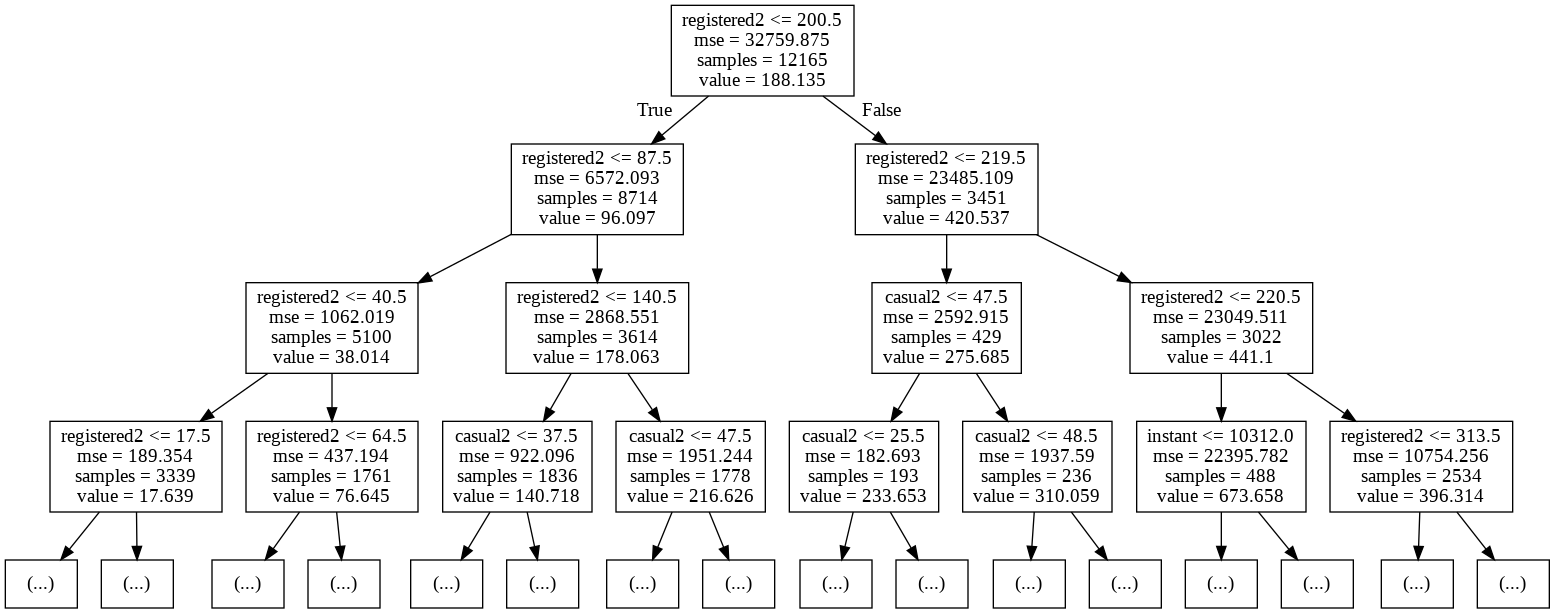

In [88]:
#import export_graphviz 
from sklearn.tree import export_graphviz  
  

dot_data = export_graphviz(rtree, out_file=None,max_depth=3,
                           feature_names=feature_train)  

#graph = graphviz.Source(dot_data)
graph = graph_from_dot_data(dot_data)

graph.write_png('tree.png')

PImage('tree.png',width=650,height=500)   # se utilizo PImage para reducir el 
                                      # tamaño del dibujo del arbol pues al 
                                      # pasarlo a pdf no se veía todo

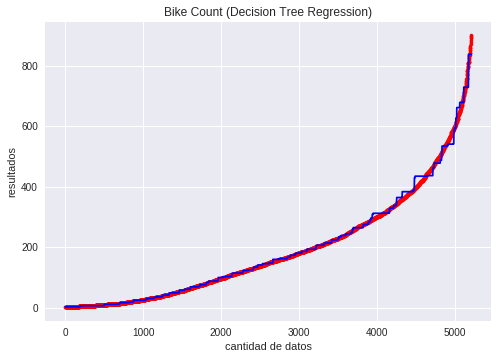

In [91]:
# x_grid son los puntos en x que tendran el tamaño de todo el vector
# nos sirve unicamente para gráficar

X_grid = np.arange(0, len(X_test), 1) 
   
  
# scatter plot de los datos originales, se realizo también un ordenamiento 
# de los datos para mejorar la visualización 

plt.plot(X_grid, np.sort(y_test), color = 'red',marker='.') 
  
# se obtiene el gráfico de la regresión del modelo entrenado del arbol

plt.plot(X_grid, np.sort(rsal), color = 'blue')  
  
# specify title 
plt.title('Bike Count (Decision Tree Regression)')  
  
# specify X axis label 
plt.xlabel('cantidad de datos') 
  
# specify Y axis label 
plt.ylabel('resultados') 
  
# show the plot 
plt.show() 

In [90]:
print('Los resultados para el primer enfoque son', E1train, E1test) 
print('Los resultados para el segundo enfoque son', E2train,E2test)
print('Los resultados para el tercer enfoque son', E3train,E3test)
print('Los resultados para el cuarto enfoque son', E4train,E4test)

print('para entrenamiento y testeo, respectivamente')


Los resultados para el primer enfoque son 0.996465897572796 0.995540057136473
Los resultados para el segundo enfoque son 0.9965084054291679 0.9955583398799388
Los resultados para el tercer enfoque son 0.9762908088101867 0.9669073963230964
Los resultados para el cuarto enfoque son 0.9786938532672376 0.9750190830849434
para entrenamiento y testeo, respectivamente


En el analisis inicial se mostro que las variables que más información aportan son la de causal y la de registered, esto se pudo constar en el segundo y tercer donde unicamente se utilizaron estas variables como vectores de carácteristicas. Si comparamos los resultados del tercer y cuarto enfoque (ambos no contienen outliers) podemos notar que cuando se utilizan las 15 carácteristicas solamente existe una mejoría de 0.09% con respecto a utilizar las dos carácteristicas más relevantes. En base a este hecho, se debería valorar la importancia de esta mejoría contra el menor uso de carga computacional al utilizar unicamente 2 carácterisicas. Sin embargo, para ambos casos los resultados son bastante aceptables.

Esta sección fue necesaria para instalar graphviz en Google colab, en ese procedimiento primero se intala anaconda y luego la librería mencionada

In [0]:
!conda install python-graphviz

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local -c pytorch -c tensorcomp tensor_comprehensions

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')